In [1]:
from collections import defaultdict
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



In [2]:
data_folder = '/home/micha/Documents/suffugium/environment_data/'
canada_df = pd.read_csv(data_folder+'Canada_cleaned.csv')    
nebraska_df = pd.read_csv(data_folder+'Nebraska_cleaned.csv')
texas_df = pd.read_csv(data_folder+'Texas_cleaned.csv') 

scenarios = {'_0': ('Open', 'Burrow'),
            '_1': ('Open_1', 'Burrow_1'),
            '_2': ('Open_2', 'Burrow_2'),
            '_3': ('Open_3', 'Burrow_3'),}
site_list = {'Canada': canada_df,
             'Nebraska': nebraska_df, 
             'Texas': texas_df}
output_dir = '../brumation_files_test/'
os.makedirs(output_dir, exist_ok=True)


for site, df in site_list.items():
    for exp, (open_col, burrow_col) in scenarios.items():
        # Find rows where either temp is < 6°C
        brumation_days = df[(df[open_col] < 10) & (df[burrow_col] < 10)].copy()

        # Create a 'MM-DD' formatted column
        brumation_days['month_day'] = (
            brumation_days['month'].astype(int).astype(str).str.zfill(2) + '-' +
            brumation_days['day'].astype(int).astype(str).str.zfill(2)
        )

        # Drop duplicates and convert to list
        dates = brumation_days['month_day'].drop_duplicates().tolist()

        # Build filename and save JSON
        key_label = site + exp
        filepath = os.path.join(output_dir, f'brumation_dates_{key_label}.json')
        with open(filepath, 'w') as f:
            json.dump({key_label: dates}, f, indent=4)

In [3]:
folder = '../brumation_files_test/'
records = []

# Efficient JSON loading
for file in os.listdir(folder):
    if file.endswith('.json'):
        with open(os.path.join(folder, file), 'r') as f:
            data = json.load(f)
            for site, dates in data.items():
                for date in dates:
                    records.append({
                        'Location': site,
                        'Date': date
                    })

# Build dataframe
brumination_df = pd.DataFrame(records)

# Convert MM-DD strings to datetime (yearless)
brumination_df['Date'] = pd.to_datetime(brumination_df['Date'], format='%m-%d', errors='coerce')

# Extract region and experiment
brumination_df[['Region', 'exp']] = brumination_df['Location'].str.extract(r'([^_]+)_(\d+)')
brumination_df['exp'] = brumination_df['exp'].astype(int)
brumination_df = brumination_df.sort_values(['Region', 'exp', 'Date']).reset_index(drop=True)

# Order locations manually
ordered_locations = [
    'Canada_0', 'Canada_1', 'Canada_2', 'Canada_3',
    'Nebraska_0', 'Nebraska_1', 'Nebraska_2', 'Nebraska_3',
    'Texas_0', 'Texas_1', 'Texas_2', 'Texas_3'
]
brumination_df['Location'] = pd.Categorical(brumination_df['Location'], categories=ordered_locations, ordered=True)


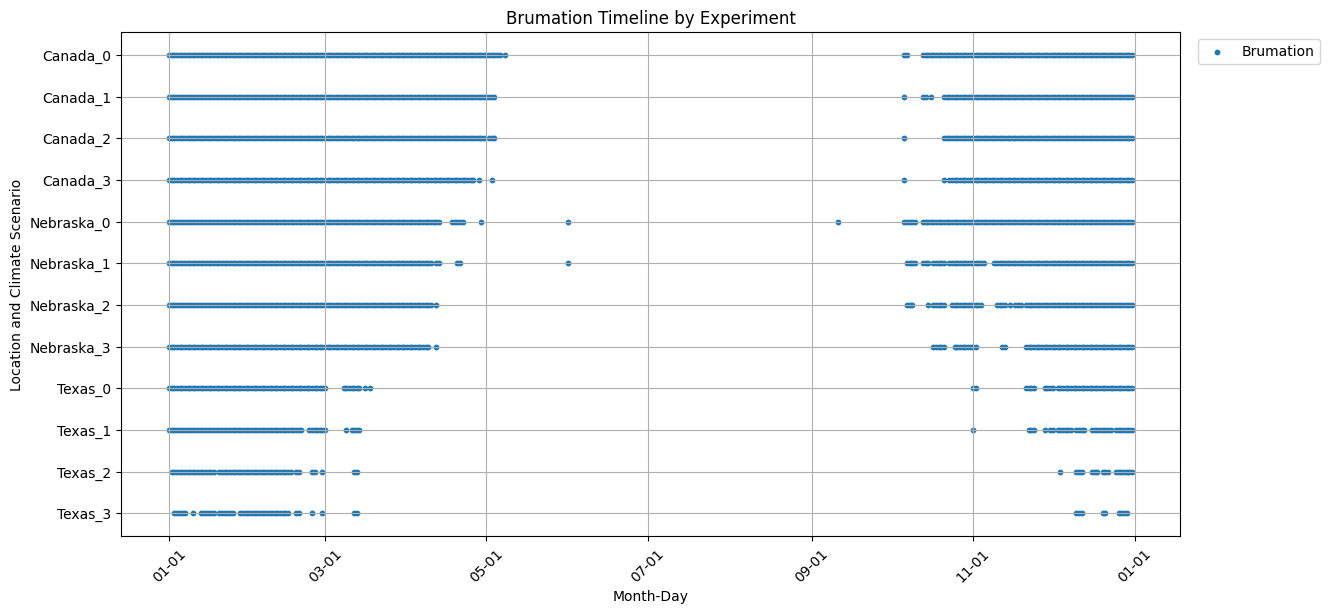

In [4]:

plt.figure(figsize=(12, 6))

plt.scatter(brumination_df['Date'], brumination_df['Location'], label='Brumation', s=10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title("Brumation Timeline by Experiment")
plt.xlabel("Month-Day")
plt.ylabel("Location and Climate Scenario")
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='medium')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Old code
climate_scenarios = ['Temperature','Temperature_1', 'Temperature_2', 'Temperature_3']
for scenario in climate_scenarios:
    exp = get_exp_name(scenario)  # Extract the base scenario name
    brumation_dates_burrow = burrow_temps[burrow_temps[scenario] < 6]
    brumation_dates_open = open_temps[open_temps[scenario] < 6]

    # Build dictionaries: {Study_Site: list of (month, day) tuples}
    brumation_dict_burrow = {
        site: list(zip(group['month'], group['day']))
        for site, group in brumation_dates_burrow.groupby('Study_Site')
    }

    # brumation_dict_open = {
    #     site: list(zip(group['month'], group['day']))
    #     for site, group in brumation_dates_open.groupby('Study_Site')
    # }
    brumation_dict_open = {}

    # Combine into one dict with union of tuples
    brumation_dict = defaultdict(set)

    for d in [brumation_dict_burrow, brumation_dict_open]:
        for site, dates in d.items():
            brumation_dict[site].update(dates)

    # Optionally convert back to regular dict with sorted lists
    brumation_dict_by_Site = {
        site: sorted(list(dates)) for site, dates in brumation_dict.items()
    }

    # # Group by site and convert to list
    # brumination_dates_by_site = brumiation_dates.groupby('Study_Site')['month_day'].unique()
    # Convert to a regular dictionary with sorted lists
    brumination_dict = {site+ '_'+ str(exp): sorted(dates) for site, dates in brumation_dict_by_Site.items()}

    # Print lists by site
    for site, dates in brumination_dict.items():
        print(f"\n{site}_{exp} Brumination Dates ({len(dates)} days):")
        date_strs = [f"{month:02d}-{day:02d}" for month, day in dates]
        print(', '.join(date_strs))

    # Save each site's list to a separate JSON file
    output_dir = '../brumination_files_test/'
    os.makedirs(output_dir, exist_ok=True)

    for site, dates in brumination_dict.items():
        # Replace spaces or special characters with underscores if needed
        filepath = os.path.join(output_dir, f'brumination_dates_{site}.json')

        # Option 1: Save as list of tuples
        # with open(filepath, 'w') as f:
        #     json.dump({site: dates}, f, indent=4)

        # Option 2: Save as list of MM-DD strings (easier to read)
        date_strs = [f"{month:02d}-{day:02d}" for month, day in dates]
        with open(filepath, 'w') as f:
            json.dump({site: date_strs}, f, indent=4)